In [1]:
cd("/home/ttthach/DrugResponseModel.jl-master-copy")

In [2]:
pwd()

"/home/ttthach/DrugResponseModel.jl-master-copy"

In [3]:
import Pkg; Pkg.instantiate()
Pkg.activate(".")

  Activating project at `~/DrugResponseModel.jl-master-copy`


In [4]:
using DelimitedFiles
using Plots
using Measures
using LinearAlgebra
using Statistics
using DSP: conv
using BlackBoxOptim
using JLD
using Distributions
using DataFrames
using XLSX
using StatsPlots
using NumericalIntegration
using CSV
using MultivariateStats
using Impute

In [5]:
using DrugResponseModel

[ Info: Precompiling DrugResponseModel [f46a7e40-ab32-11e9-0ff4-0323d592fbfd]
  ** incremental compilation may be fatally broken for this module **

┌ Warning: Replacing docs for `DrugResponseModel.plot_fig1 :: NTuple{8, Any}` in module `DrugResponseModel`
└ @ Base.Docs docs/Docs.jl:240


In [ ]:
function plot_fig(concs, g1, g1data, tite, G, subPlabel, palet, time)
    p = Plots.plot(
        time,
        g1,
        lw = 2.5,
        legend = :outertopright,
        label = ["control" "$(concs[4]) nM" "$(concs[5]) nM" "$(concs[6]) nM" "$(concs[7]) nM" "$(concs[8]) nM"],
        fg_legend = :transparent,
        palette = palet,
        title = tite,
        titlefont = Plots.font("Helvetica", 14),
        legendfont = Plots.font("Helvetica", 11),
        guidefont = Plots.font("Helvetica", 14),
        xtickfont = Plots.font("Helvetica", 14),
        ytickfont = Plots.font("Helvetica", 14),
        xlabel = "time [hr]",
        xticks = 0:24.0:96.0,
        ylabel = "$G cell number",
        bottom_margin = 1.25cm,
        top_margin = 1.25cm,
        left_margin = 1.25cm,
        right_margin = 1.25cm,
    )
    Plots.plot!(time, g1data, lw = 0.75, linestyle = :dash, label = ["" "" "" "" "" "" ""])
    annotate!(-1.0, 2.0, Plots.text(subPlabel, :black, :left, Plots.font("Helvetica Bold", 15)))
    ylims!((0.0, 2.5))
    Plots.plot!(size = (750,500))
    p
end

function SSE(G1_l, G2_l, G1_d, G2_d, G1_g, G2_g, g1m, g2m, subPlabel, num)
    SSEs = zeros(3, num)
    for i = 1:num
        SSEs[1, i] = norm(G1_l[:, :, i] - g1m[:, :, 1]) + norm(G2_l[:, :, i] - g2m[:, :, 1])
        SSEs[2, i] = norm(G1_d[:, :, i] - g1m[:, :, 2]) + norm(G2_d[:, :, i] - g2m[:, :, 2])
        SSEs[3, i] = norm(G1_g[:, :, i] - g1m[:, :, 3]) + norm(G2_g[:, :, i] - g2m[:, :, 3])
    end
        
    ctg = repeat(["G1 = 8, G2 = 20", "G1 = 8, G2 = 16", "G1 = 12, G2 = 32", "G1 = 8, G2 = 32", "G1 = 12, G2 = 20"
            , "G1 = 8, G2 = 24"], inner = 3)
    nam = repeat(["Lapatinib", "Doxorubicin", "Gemcitabine"], outer = num)

    StatsPlots.groupedbar(
        nam,
        SSEs,
        group = ctg,
        xrotation = 30,
        xlabel = "Drugs",
        ylabel = "SSE",
        title = "Sum of Squared Errors",
        bar_width = 0.45,
        lw = 0,
        legend = :outertopright,
        framestyle = :box,
        titlefont = Plots.font("Helvetica", 14),
        legendfont = Plots.font("Helvetica", 11),
        guidefont = Plots.font("Helvetica", 14),
        xtickfont = Plots.font("Helvetica", 14),
        ytickfont = Plots.font("Helvetica", 14),
        bottom_margin = 1.25cm,
        fg_legend = :transparent,
#        top_margin = 1.25cm,
        left_margin = 1.85cm,
        right_margin = 1.25cm,
        size = (1000,500)
    )
    annotate!(-1, 555.0, Plots.text(subPlabel, :black, :left, Plots.font("Helvetica Bold", 15)))
end

In [6]:
concs, popul1, g1s1, g2s1 = DrugResponseModel.load(189, 1)
_, popul2, g1s2, g2s2 = DrugResponseModel.load(189, 2)
_, popul3, g1s3, g2s3 = DrugResponseModel.load(189, 3)


([0.0 0.0 … 0.0 0.0; 5.0 1.0 … 0.1 5.0; … ; 250.0 250.0 … 7.5 250.0; 500.0 500.0 … 15.0 500.0], [1.0032552758407909 1.0064612560713013 … 0.9959833933984756 1.0124062968468779; 1.0049364864014496 1.0026917936163586 … 0.9976455939066555 1.011377149926648; … ; 3.249165008337334 2.9901321599853237 … 1.208090989564976 0.894549578639598; 3.274549731108837 3.0125403565936155 … 1.209007002608449 0.892277179016143;;; 0.997203641903921 0.9961100948698294 … 1.0011748244642855 0.99978661376521; 1.000706565142862 0.9993386509641615 … 1.0053058716457053 1.0018673376487444; … ; 3.2724030194074705 3.180575285477375 … 0.32771915689831066 0.12489986566415762; 3.294466443540144 3.1993963697695933 … 0.32597947065836586 0.12572614051781378;;; 1.0066061988264159 1.0056121022515114 … 0.9931905200278262 0.9875048237994419; 1.0058879972330903 1.0057855407344256 … 0.9962906137115045 0.9939668843092728; … ; 3.4823312191318836 3.22793313646392 … 0.5231419581792258 0.3830895365664406; 3.5070224231734493 3.24835303

In [7]:
# find the average of the three replicates
g1S = cat(g1s1, g1s2, g1s3, dims = 4)
g2S = cat(g2s1, g2s2, g2s3, dims = 4)
g1m = mean(g1S, dims = 4) # mean G1
g2m = mean(g2S, dims = 4) # mean G2

time = LinRange(0.0, 95.0, 189)

189-element LinRange{Float64, Int64}:
 0.0,0.505319,1.01064,1.51596,2.02128,…,92.9787,93.484,93.9894,94.4947,95.0

In [23]:
l_cost_820, l_hill_820 = optimize_hill(concs[:, 1], g1m[:, :, 1], g2m[:, :, 1], 
maxstep = 100000, num_parts = 4, 
g1_lower = 1, g1_upper = 4, g2_lower = 3, g2_upper = 10)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
DE modify state:
100.01 secs, 10542 evals, 10438 steps, improv/step: 0.164 (last = 0.1643), fitness=407.421795269
DE modify state:
200.01 secs, 25368 evals, 25265 steps, improv/step: 0.147 (last = 0.1352), fitness=197.274586700
DE modify state:
300.01 secs, 37780 evals, 37677 steps, improv/step: 0.142 (last = 0.1309), fitness=182.188423565
DE modify state:
400.02 secs, 50341 evals, 50238 steps, improv/step: 0.137 (last = 0.1236), fitness=176.065768014
DE modify state:
500.02 secs, 62411 evals, 62310 steps, improv/step: 0.135 (last = 0.1232), fitness=172.070398542
DE modify state:
600.02 secs, 74492 evals, 74396 steps, improv/step: 0.134 (last = 0.1306), fitness=169.747330734
DE modify state:
700.03 secs, 86126 evals, 86035 steps, improv/step: 0.134 (last = 0.1323), fitness=167.20981397

(165.3132656452916, [34.842187748647106, 1.3944212556153337, 0.09575850243519152, 0.010761661870766923, 0.07000614781742147, 0.16245615202431238, 2.258308792041694, 3.2157446889525176, 0.005438958765349208, 0.398729000344071  …  0.16179657904721664, 0.28976538233509946, 0.9340949104101203, 1.3880994884870914, 2.369093277129307, 3.410598037228695, 3.995888096759099, 0.30616242555680834, 2.116487372372504, 8.009442337777747])

In [24]:
# converting the Hill parameters to ODE parameters
num_params = length(l_hill_820) - 2
nG1_fit = trunc(Int, l_hill_820[num_params + 1])
nG2_fit = trunc(Int, l_hill_820[num_params + 2])

l_hill_ODE_820 = getODEparams(l_hill_820[1:num_params], concs[:, 1], n)

l_G1_820 = zeros(189, 8) # model prediction of cell numbers for all 8 concentrations of lapatinib
l_G2_820 = zeros(189, 8)

#default: nG1 = 8, nG2 = 20  
for i = 1:8
    l_G1_820[:, i], l_G2_820[:, i], _ = 
    DrugResponseModel.predict(l_hill_ODE_820[:, i, 1], l_hill_ODE_820[:, 1, 1], time, n, nG1_fit, nG2_fit)
end

In [26]:
#shorten array for plotting
l_G1_s820= zeros(189, 6)
l_G2_s820= zeros(189, 6)

l_G1_s820[:, 1] .= l_G1_820[:, 1]
l_G1_s820[:, 2:6] .= l_G1_820[:, 4:8]
l_G2_s820[:, 1] .= l_G2_820[:, 1]
l_G2_s820[:, 2:6] .= l_G2_820[:, 4:8]


g1mshort = zeros(189, 6, 5)
g2mshort = zeros(189, 6, 5)
g1mshort[:, 1, :] .= g1m[:, 1, :]
g1mshort[:, 2:6, :] .= g1m[:, 4:8, :]
g2mshort[:, 1, :] .= g2m[:, 1, :]
g2mshort[:, 2:6, :] .= g2m[:, 4:8, :]


189×5×5 view(::Array{Float64, 3}, :, 2:6, :) with eltype Float64:
[:, :, 1] =
 0.350185  0.330961  0.36563   0.306652  0.325709
 0.357677  0.339829  0.371686  0.314795  0.336574
 0.364381  0.348008  0.376961  0.321912  0.346208
 0.370331  0.355508  0.381479  0.328038  0.354653
 0.375558  0.362341  0.385261  0.333209  0.361953
 0.380095  0.368519  0.388331  0.337459  0.368152
 0.383976  0.374052  0.390712  0.340825  0.373294
 0.387232  0.378952  0.392427  0.343342  0.37742
 0.389897  0.38323   0.393499  0.345044  0.380576
 0.392004  0.386898  0.393951  0.345968  0.382805
 0.393585  0.389966  0.393805  0.346148  0.384149
 0.394673  0.392447  0.393085  0.345621  0.384653
 0.3953    0.394352  0.391813  0.34442   0.38436
 ⋮                                       
 1.07829   0.701502  0.425512  0.259445  0.137072
 1.08858   0.706187  0.423977  0.257946  0.136033
 1.09936   0.711232  0.422599  0.256341  0.1349
 1.11065   0.716642  0.421392  0.254624  0.133668
 1.12246   0.72242   0.420375  0.2

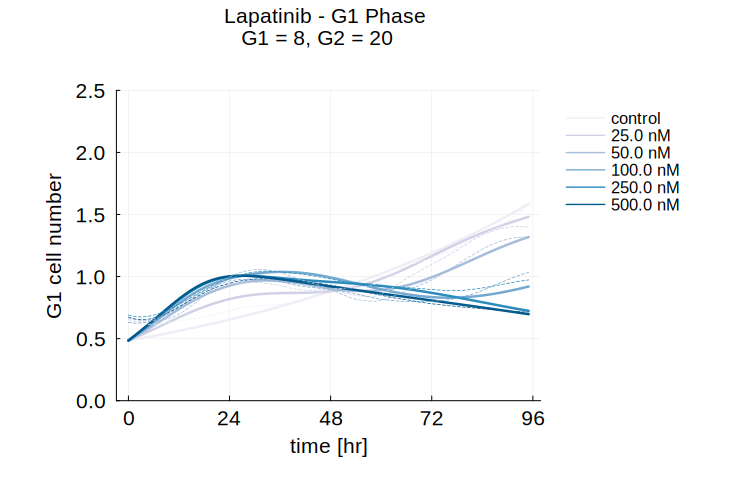

In [27]:
pl_G1_820 = plot_fig(concs[:, 1], l_G1_s820[:, :], g1mshort[:, :, 1, 1], 
    "Lapatinib - G1 Phase 
    G1 = 8, G2 = 20", "G1", "", :PuBu_6, time)


pl_G1_820   

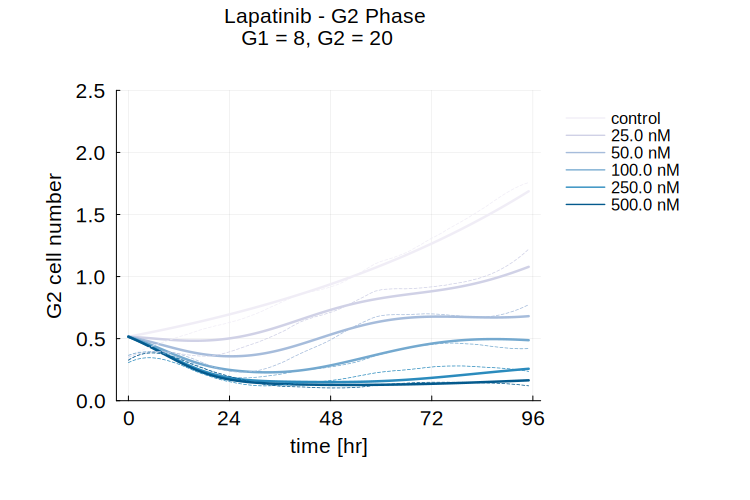

In [28]:
pl_G2_820 = plot_fig(concs[:, 1], l_G2_s820[:, :], g2mshort[:, :, 1, 1], 
    "Lapatinib - G2 Phase 
    G1 = 8, G2 = 20", "G2", "", :PuBu_6, time)

pl_G2_820

In [29]:
l_cost_8, l_hill_8 = optimize_hill(concs[:, 1], g1m[:, :, 1], g2m[:, :, 1], 
maxstep = 100000, num_parts = 8, 
g1_lower = 1, g1_upper = 4, g2_lower = 2, g2_upper = 10)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
DE modify state:
100.02 secs, 2707 evals, 2589 steps, improv/step: 0.200 (last = 0.2001), fitness=631.124597545
DE modify state:
200.03 secs, 5425 evals, 5307 steps, improv/step: 0.146 (last = 0.0946), fitness=582.212873031
DE modify state:
300.03 secs, 7882 evals, 7764 steps, improv/step: 0.128 (last = 0.0875), fitness=564.241808870
DE modify state:
400.04 secs, 10007 evals, 9889 steps, improv/step: 0.122 (last = 0.1040), fitness=557.429266274
DE modify state:
500.16 secs, 11965 evals, 11847 steps, improv/step: 0.118 (last = 0.0975), fitness=553.531907448
DE modify state:
600.17 secs, 14049 evals, 13931 steps, improv/step: 0.116 (last = 0.1041), fitness=551.978777919
DE modify state:
700.18 secs, 16563 evals, 16446 steps, improv/step: 0.115 (last = 0.1070), fitness=550.551172875
DE mo

(165.68438010600514, [51.45068920051502, 1.226182951618892, 2.2139819325233216, 1.5835988714391918, 0.2671398284899269, 0.0565019952628486, 0.59452397253348, 0.728824663504474, 0.03474211829683497, 0.40031243558421514  …  3.9987547085972635, 3.966725647579186, 3.3621536884865075, 3.8491823311484232, 0.7202454729296425, 3.701394234102362, 1.0624535916779312, 0.33668820946664874, 3.8153764410198963, 5.862115642848654])

In [ ]:
n = 8
# converting the Hill parameters to ODE parameters
num_params = length(l_hill_8) - 2
nG1_fit_8 = trunc(Int, l_hill_8[num_params + 1])
nG2_fit_8 = trunc(Int, l_hill_8[num_params + 2])

l_hill_ODE_8 = getODEparams(l_hill_8[1:num_params], concs[:, 1], n)

l_G1_8 = zeros(189, 8) # model prediction of cell numbers for all 8 concentrations of lapatinib
l_G2_8 = zeros(189, 8)

for i = 1:8
    l_G1_8[:, i], l_G2_8[:, i], _ = 
    DrugResponseModel.predict(l_hill_ODE_8[:, i, 1], l_hill_ODE_8[:, 1, 1], time, n, nG1_fit_8, nG2_fit_8)
end

#shorten array for plotting
l_G1_s8= zeros(189, 6)
l_G2_s8= zeros(189, 6)

l_G1_s8[:, 1] .= l_G1_8[:, 1]
l_G1_s8[:, 2:6] .= l_G1_8[:, 4:8]
l_G2_s8[:, 1] .= l_G2_8[:, 1]
l_G2_s8[:, 2:6] .= l_G2_8[:, 4:8]


g1mshort = zeros(189, 6, 5)
g2mshort = zeros(189, 6, 5)
g1mshort[:, 1, :] .= g1m[:, 1, :]
g1mshort[:, 2:6, :] .= g1m[:, 4:8, :]
g2mshort[:, 1, :] .= g2m[:, 1, :]
g2mshort[:, 2:6, :] .= g2m[:, 4:8, :]


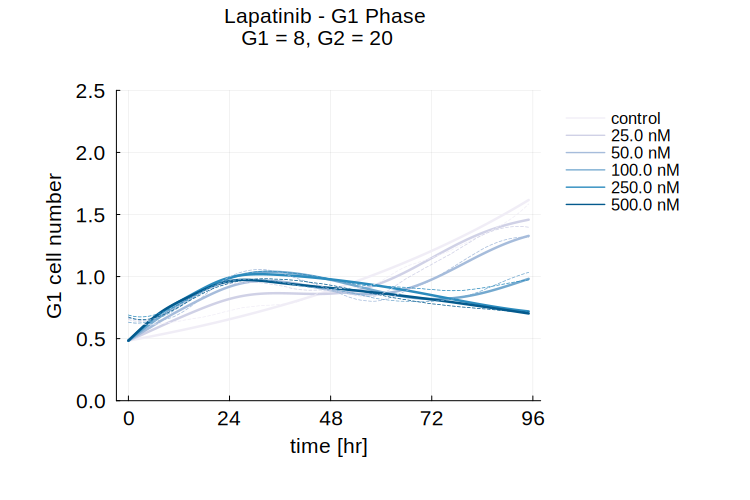

In [ ]:
pl_G1_8 = plot_fig(concs[:, 1], l_G1_s8[:, :], g1mshort[:, :, 1, 1], 
    "Lapatinib - G1 Phase 
    G1 = 8, G2 = 20", "G1", "", :PuBu_6, time)

pl_G1_8   

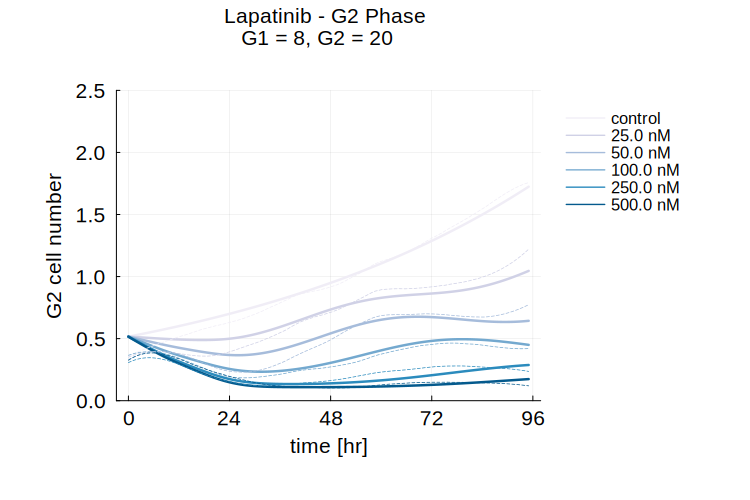

In [34]:
pl_G2_8 = plot_fig(concs[:, 1], l_G2_s8[:, :], g2mshort[:, :, 1, 1], 
    "Lapatinib - G2 Phase 
    G1 = 8, G2 = 20", "G2", "", :PuBu_6, time)

pl_G2_8

In [35]:
l_cost_2, l_hill_2 = optimize_hill(concs[:, 1], g1m[:, :, 1], g2m[:, :, 1], 
maxstep = 100000, num_parts = 2, 
g1_lower = 1, g1_upper = 10, g2_lower = 1, g2_upper = 10)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
DE modify state:
100.00 secs, 32399 evals, 32297 steps, improv/step: 0.130 (last = 0.1302), fitness=180.925560501
DE modify state:
200.00 secs, 75514 evals, 75416 steps, improv/step: 0.138 (last = 0.1431), fitness=166.579015236
DE modify state:

Optimization stopped after 100001 steps and 263.84 seconds
Termination reason: Max number of steps (100000) reached
Steps per second = 379.02
Function evals per second = 379.38
Improvements/step = 0.13725
Total function evaluations = 100095


Best candidate found: [37.8903, 1.39709, 0.314302, 0.0641756, 0.162992, 0.226142, 0.022208, 0.0055932, 2.55953e-5, 0.000303422, 0.6155, 0.475078, 0.285782, 0.121825, 6.80904, 3.24298]

Fitness: 164.257482629



(164.25748262905438, [37.89031909337541, 1.3970890564511975, 0.3143022717735968, 0.06417556346346649, 0.16299241235018158, 0.22614232751597008, 0.022208007358282718, 0.005593203293134864, 2.5595254721220636e-5, 0.000303422468282867, 0.615499667002744, 0.4750783958034871, 0.28578240769339636, 0.12182465204134815, 6.809036700991258, 3.2429832847018])

In [ ]:
n = 2
# converting the Hill parameters to ODE parameters
num_params = length(l_hill_2) - 2
nG1_fit_2 = trunc(Int, l_hill_2[num_params + 1])
nG2_fit_2 = trunc(Int, l_hill_2[num_params + 2])

l_hill_ODE_2 = getODEparams(l_hill_2[1:num_params], concs[:, 1], n)

l_G1_2 = zeros(189, 8) # model prediction of cell numbers for all 8 concentrations of lapatinib
l_G2_2 = zeros(189, 8)

for i = 1:8
    l_G1_2[:, i], l_G2_2[:, i], _ = 
    DrugResponseModel.predict(l_hill_ODE_2[:, i, 1], l_hill_ODE_2[:, 1, 1], time, n, nG1_fit_2, nG2_fit_2)
end

#shorten array for plotting
l_G1_s2= zeros(189, 6)
l_G2_s2= zeros(189, 6)

l_G1_s2[:, 1] .= l_G1_2[:, 1]
l_G1_s2[:, 2:6] .= l_G1_2[:, 4:8]
l_G2_s2[:, 1] .= l_G2_2[:, 1]
l_G2_s2[:, 2:6] .= l_G2_2[:, 4:8]


g1mshort = zeros(189, 6, 5)
g2mshort = zeros(189, 6, 5)
g1mshort[:, 1, :] .= g1m[:, 1, :]
g1mshort[:, 2:6, :] .= g1m[:, 4:8, :]
g2mshort[:, 1, :] .= g2m[:, 1, :]
g2mshort[:, 2:6, :] .= g2m[:, 4:8, :]


189×5×5 view(::Array{Float64, 3}, :, 2:6, :) with eltype Float64:
[:, :, 1] =
 0.350185  0.330961  0.36563   0.306652  0.325709
 0.357677  0.339829  0.371686  0.314795  0.336574
 0.364381  0.348008  0.376961  0.321912  0.346208
 0.370331  0.355508  0.381479  0.328038  0.354653
 0.375558  0.362341  0.385261  0.333209  0.361953
 0.380095  0.368519  0.388331  0.337459  0.368152
 0.383976  0.374052  0.390712  0.340825  0.373294
 0.387232  0.378952  0.392427  0.343342  0.37742
 0.389897  0.38323   0.393499  0.345044  0.380576
 0.392004  0.386898  0.393951  0.345968  0.382805
 0.393585  0.389966  0.393805  0.346148  0.384149
 0.394673  0.392447  0.393085  0.345621  0.384653
 0.3953    0.394352  0.391813  0.34442   0.38436
 ⋮                                       
 1.07829   0.701502  0.425512  0.259445  0.137072
 1.08858   0.706187  0.423977  0.257946  0.136033
 1.09936   0.711232  0.422599  0.256341  0.1349
 1.11065   0.716642  0.421392  0.254624  0.133668
 1.12246   0.72242   0.420375  0.2

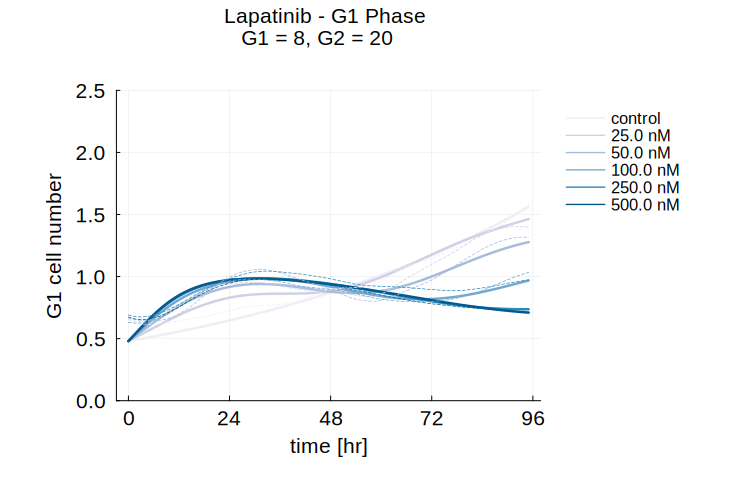

In [37]:
pl_G1_2 = plot_fig(concs[:, 1], l_G1_s2[:, :], g1mshort[:, :, 1, 1], 
    "Lapatinib - G1 Phase 
    G1 = 8, G2 = 20", "G1", "", :PuBu_6, time)

pl_G1_2  

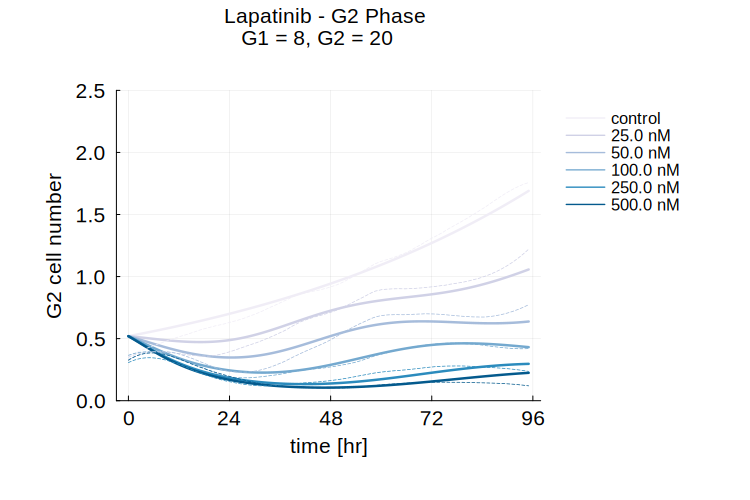

In [38]:
pl_G2_2 = plot_fig(concs[:, 1], l_G2_s2[:, :], g2mshort[:, :, 1, 1], 
    "Lapatinib - G2 Phase 
    G1 = 8, G2 = 20", "G2", "", :PuBu_6, time)

pl_G2_2

In [39]:
l_cost_3, l_hill_3 = optimize_hill(concs[:, 1], g1m[:, :, 1], g2m[:, :, 1], 
maxstep = 100000, num_parts = 3, 
g1_lower = 1, g1_upper = 10, g2_lower = 1, g2_upper = 10)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
DE modify state:
100.01 secs, 10146 evals, 10031 steps, improv/step: 0.135 (last = 0.1351), fitness=547.799207195
DE modify state:
200.01 secs, 20479 evals, 20364 steps, improv/step: 0.144 (last = 0.1531), fitness=387.579951575
DE modify state:
300.02 secs, 32849 evals, 32734 steps, improv/step: 0.148 (last = 0.1530), fitness=182.998465816
DE modify state:
400.02 secs, 45940 evals, 45825 steps, improv/step: 0.142 (last = 0.1285), fitness=177.706150253
DE modify state:
500.02 secs, 59018 evals, 58905 steps, improv/step: 0.139 (last = 0.1300), fitness=172.297533774
DE modify state:
600.03 secs, 73337 evals, 73225 steps, improv/step: 0.137 (last = 0.1283), fitness=165.375794619
DE modify state:
700.03 secs, 87969 evals, 87860 steps, improv/step: 0.134 (last = 0.1194), fitness=163.36110189

(162.96070619009143, [19.39780086341536, 1.3252047542020737, 0.09258090857905045, 0.30642229318658254, 0.05479164204689135, 0.31299321665455604, 3.551397018900109, 3.7535169681544533, 0.020466801237022797, 1.716190202694621e-5  …  0.0001113213315138041, 0.00038129307078093124, 3.999447602511663, 0.2728148944178692, 0.606017540014583, 0.27346240305788555, 3.520552310032366, 3.7315214637432743, 4.219066634221422, 8.725207606104725])

In [40]:
n = 3
# converting the Hill parameters to ODE parameters
num_params = length(l_hill_3) - 2
nG1_fit_3 = trunc(Int, l_hill_3[num_params + 1])
nG2_fit_3 = trunc(Int, l_hill_3[num_params + 2])

l_hill_ODE_3 = getODEparams(l_hill_3[1:num_params], concs[:, 1], n)

l_G1_3 = zeros(189, 8) # model prediction of cell numbers for all 8 concentrations of lapatinib
l_G2_3 = zeros(189, 8)

for i = 1:8
    l_G1_3[:, i], l_G2_3[:, i], _ = 
    DrugResponseModel.predict(l_hill_ODE_3[:, i, 1], l_hill_ODE_3[:, 1, 1], time, n, nG1_fit_3, nG2_fit_3)
end

#shorten array for plotting
l_G1_s3= zeros(189, 6)
l_G2_s3= zeros(189, 6)

l_G1_s3[:, 1] .= l_G1_3[:, 1]
l_G1_s3[:, 2:6] .= l_G1_3[:, 4:8]
l_G2_s3[:, 1] .= l_G2_3[:, 1]
l_G2_s3[:, 2:6] .= l_G2_3[:, 4:8]


g1mshort = zeros(189, 6, 5)
g2mshort = zeros(189, 6, 5)
g1mshort[:, 1, :] .= g1m[:, 1, :]
g1mshort[:, 2:6, :] .= g1m[:, 4:8, :]
g2mshort[:, 1, :] .= g2m[:, 1, :]
g2mshort[:, 2:6, :] .= g2m[:, 4:8, :]


189×5×5 view(::Array{Float64, 3}, :, 2:6, :) with eltype Float64:
[:, :, 1] =
 0.350185  0.330961  0.36563   0.306652  0.325709
 0.357677  0.339829  0.371686  0.314795  0.336574
 0.364381  0.348008  0.376961  0.321912  0.346208
 0.370331  0.355508  0.381479  0.328038  0.354653
 0.375558  0.362341  0.385261  0.333209  0.361953
 0.380095  0.368519  0.388331  0.337459  0.368152
 0.383976  0.374052  0.390712  0.340825  0.373294
 0.387232  0.378952  0.392427  0.343342  0.37742
 0.389897  0.38323   0.393499  0.345044  0.380576
 0.392004  0.386898  0.393951  0.345968  0.382805
 0.393585  0.389966  0.393805  0.346148  0.384149
 0.394673  0.392447  0.393085  0.345621  0.384653
 0.3953    0.394352  0.391813  0.34442   0.38436
 ⋮                                       
 1.07829   0.701502  0.425512  0.259445  0.137072
 1.08858   0.706187  0.423977  0.257946  0.136033
 1.09936   0.711232  0.422599  0.256341  0.1349
 1.11065   0.716642  0.421392  0.254624  0.133668
 1.12246   0.72242   0.420375  0.2

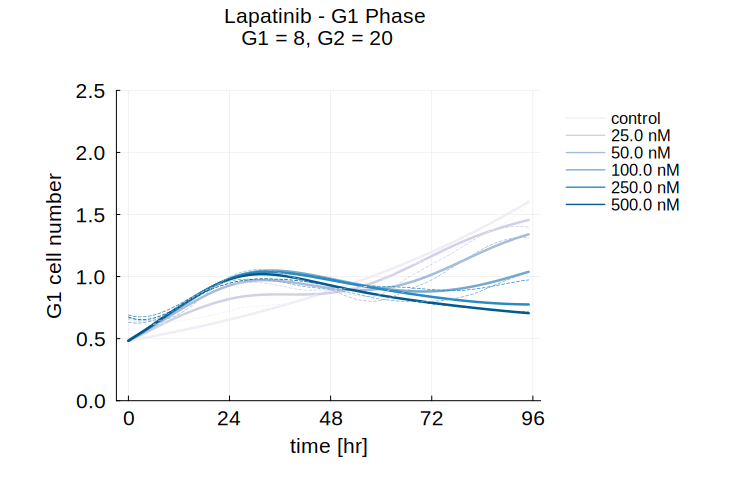

In [41]:
pl_G1_3 = plot_fig(concs[:, 1], l_G1_s3[:, :], g1mshort[:, :, 1, 1], 
    "Lapatinib - G1 Phase 
    G1 = 8, G2 = 20", "G1", "", :PuBu_6, time)

pl_G1_3

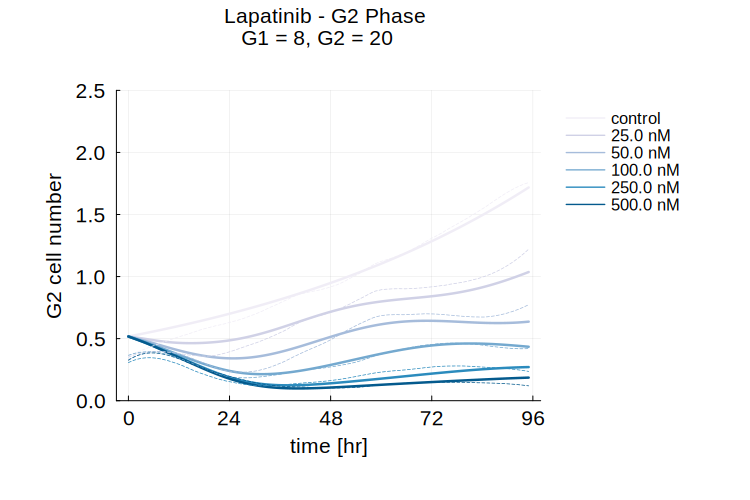

In [42]:
pl_G2_3 = plot_fig(concs[:, 1], l_G2_s3[:, :], g2mshort[:, :, 1, 1], 
    "Lapatinib - G2 Phase 
    G1 = 8, G2 = 20", "G2", "", :PuBu_6, time)

pl_G2_3

In [ ]:
l_cost_6, l_hill_6 = optimize_hill(concs[:, 1], g1m[:, :, 1], g2m[:, :, 1], 
maxstep = 100000, num_parts = 6, 
g1_lower = 1, g1_upper = 10, g2_lower = 1, g2_upper = 10)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
DE modify state:
100.01 secs, 1344 evals, 1223 steps, improv/step: 0.271 (last = 0.2706), fitness=628.384900193
DE modify state:
200.08 secs, 2475 evals, 2354 steps, improv/step: 0.215 (last = 0.1556), fitness=565.761159510
DE modify state:
300.12 secs, 3677 evals, 3556 steps, improv/step: 0.179 (last = 0.1082), fitness=565.761159510
DE modify state:
400.25 secs, 4894 evals, 4773 steps, improv/step: 0.160 (last = 0.1052), fitness=561.775854829
DE modify state:
500.25 secs, 6193 evals, 6072 steps, improv/step: 0.146 (last = 0.0924), fitness=555.458173900
DE modify state:
600.26 secs, 7465 evals, 7344 steps, improv/step: 0.132 (last = 0.0660), fitness=555.458173900
DE modify state:
700.31 secs, 8854 evals, 8733 steps, improv/step: 0.123 (last = 0.0734), fitness=554.580183180
DE modify st

In [ ]:
# Baseline (4 parts, 2 sub-parts G1, 5 sub-parts G2)
# Lapatinib - 690.75 seconds
# Best candidate found: [14.5528, 1.10421, 0.269358, 0.298295, 0.00146288, 0.0136185, 0.108805, 0.797301, 0.540014, 0.366761, 0.000301454, 0.0612737, 0.0115851, 5.91166e-5, 0.00135124, 0.000200483, 0.000792564, 0.00027015, 0.163048, 3.81887, 3.45587, 0.214637, 2.526, 0.911031, 0.671934, 0.26215, 2.0, 5.0]
# Fitness: 152.470768516
# 
# Doxorubicin - 327.11 seconds
# Best candidate found: [19.9524, 1.56237, 2.79479e-5, 0.000181991, 0.168814, 0.00348551, 0.143713, 2.69463, 2.98464, 0.606343, 0.0432688, 0.00200019, 8.46284e-5, 0.0497697, 1.71924e-5, 0.652381, 0.00121545, 0.000227081, 3.99524, 0.71949, 0.103426, 3.99923, 0.266001, 2.67285, 3.86273, 0.427602, 2.0, 5.0]
# Fitness: 187.544440327
# 
# Gemcitabine - 326.87 seconds
# Best candidate found: [4.88502, 2.24698, 0.600245, 3.99557, 0.229319, 0.135877, 6.67332e-5, 2.60289, 0.0733976, 0.709055, 2.39619e-6, 7.15212e-6, 1.23623e-6, 7.03453e-8, 0.0376025, 7.01328e-6, 1.71246e-8, 1.82961e-6, 3.99973, 3.99686, 0.117107, 0.620957, 3.99968, 3.89432, 0.258915, 0.475671, 2.0, 5.0]
# Fitness: 207.531937350

In [ ]:
# G1, G2 Fits (4 parts, 1:10 sub-part range)
# Lapatinib - 1533.56 seconds
# Best candidate found: [43.3467, 1.4243, 0.146426, 0.0934763, 0.928829, 0.745213, 2.846, 3.92527, 2.30403, 0.527174, 0.0178441, 0.00160078, 1.11934e-5, 0.00565242, 0.000169512, 0.00680425, 0.0150192, 0.00730093, 0.556205, 0.536633, 1.78201, 3.95919, 2.98896, 3.93534, 3.98322, 0.341966, 5.00437, 9.05714]
# Fitness: 163.745984085
# 
# Doxorubicin - 1461.30 seconds
# Best candidate found: [16.4881, 1.51069, 3.14948, 0.669587, 2.1584, 1.64428e-5, 1.79155, 0.837405, 2.31273, 0.0922798, 0.000165741, 5.39735e-6, 1.13219e-5, 0.0393222, 0.101723, 7.9388e-5, 5.78791e-5, 0.0117852, 3.1446, 0.623061, 3.65273, 3.99969, 1.81918, 2.34312, 3.99269, 0.227449, 9.78104, 6.96051]
# Fitness: 228.624023262
#
# Gemcitabine - 1755.36 seconds
# Best candidate found: [4.22481, 1.77387, 3.93148, 3.56753, 2.62173, 0.777903, 0.213283, 0.314864, 2.17244, 0.379366, 0.000179884, 0.000215301, 3.33036e-5, 5.92074e-6, 2.3883e-5, 0.107374, 0.000676514, 5.06133e-6, 3.92021, 3.54542, 2.57546, 0.78592, 0.433843, 3.99404, 3.90015, 0.274836, 9.46046, 5.33931]
# Fitness: 237.091775345
# 
#

In [ ]:
# G1, G2 Fits (2 parts, 1:10 sub-part range)
# Lapatinib - 276.11 seconds
# Best candidate found: [40.5805, 1.39167, 0.314718, 0.0497532, 0.661533, 0.436326, 0.027462, 0.00557057, 3.35177e-7, 8.25927e-7, 0.616319, 0.347711, 1.25062, 0.288994, 5.75282, 8.48255]
# Fitness: 163.174303438 
# 
# Doxorubicin - 432.53 seconds
# Best candidate found: [92.2845, 0.943416, 3.32759, 0.251861, 0.320168, 1.28319, 1.24316e-7, 8.91744e-9, 0.114162, 2.35796e-8, 3.32508, 0.356999, 0.343721, 1.23454, 7.07277, 9.70969]
# Fitness: 261.358400011
# 
# Gemcitabine - 310.30 seconds
# Best candidate found: [5.45423, 1.83508, 0.955573, 1.11727, 0.100249, 0.276678, 7.18697e-9, 5.52142e-7, 0.0298713, 6.05272e-8, 0.496084, 3.99998, 0.663634, 0.199142, 9.35345, 5.92299]
# Fitness: 231.303013379# 

In [ ]:
# G1, G2 Fits (2 parts, 1:20 sub-part range)
# Lapatinib - 904.42 seconds
# Best candidate found: [43.5723, 1.39569, 0.48353, 0.11383, 2.14217, 0.480466, 0.0224921, 0.00408752, 8.78985e-5, 0.00744783, 1.31641, 0.583601, 3.1128, 0.32521, 9.0945, 10.8508]
# Fitness: 164.083868699
#
# Doxorubicin - 2635.11 seconds
# Best candidate found: [18.7279, 1.37703, 0.90149, 7.07894e-7, 2.9179, 0.218704, 3.03252e-8, 0.0299411, 0.0511971, 0.0147141, 0.895859, 3.99999, 3.99992, 0.625025, 16.3014, 18.1883]
# Fitness: 236.290909211# 
#
# Gemcitabine - 2111.45 seconds
# Best candidate found: [7.70047, 1.88825, 0.975827, 0.0727604, 0.113152, 3.87422, 1.0e-9, 0.0371608, 1.00002e-9, 1.00002e-9, 0.784715, 4.0, 0.704577, 3.86426, 13.6608, 19.071]
# Fitness: 252.824647259

In [ ]:
# G1, G2 Fits (1 part, 1:20 sub-part range)
# Lapatinib - 350.00 seconds
# Best candidate found: [51.5503, 1.53588, 0.175393, 0.595709, 0.00847739, 0.00998386, 0.659609, 0.4473, 15.7847, 15.3925]
# Fitness: 171.278699448#
#
# Doxorubicin - 326.13 seconds
# Best candidate found: [113.548, 0.928761, 0.329615, 0.509362, 1.0e-9, 0.106115, 0.554965, 0.418352, 12.4638, 14.1601]
# Fitness: 263.763263280#
#
# Gemcitabine - 2111.45 seconds
# Best candidate found: [7.70047, 1.88825, 0.975827, 0.0727604, 0.113152, 3.87422, 1.0e-9, 0.0371608, 1.00002e-9, 1.00002e-9, 0.784715, 4.0, 0.704577, 3.86426, 13.6608, 19.071]
# Fitness: 252.824647259